In [1]:
# Imports
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from lib.utility_functions import *
from lib.exp4 import *

# Config
sns.set_style('white')
sns.set_context('talk')

pd.set_option('display.max_columns', 40)

% matplotlib inline

/Users/gianni/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)

In [3]:
# Are subjects more likely to reproduce some features than others?
# Are trained subjects more likely to reproduce game set features?

In [4]:
hstarts = [i for row in range(4) for i in range(9*row, 9*row + 6, 1)]
vstarts = list(range(9))
ddstarts = list(range(6))
dustarts = list(range(4, 9))


def _add_position_strings(bp, wp):
    return ''.join([str(int(b) + int(w)) for b, w in zip(bp, wp)])


def _count_feature(bp, wp, feature):
    
    # Get the overall occupancy of position
    p = _add_position_strings(bp, wp)

    # Initialize count matrices
    bcounts = np.zeros(36, dtype=np.uint8)
    wcounts = np.zeros(36, dtype=np.uint8)
    
    # Helper function to detect matchs in different orientations
    def _orient_count(start, increment):
    
        end = start + 4 * increment

        for orientation in [1, -1]:
            total_match = p[start:end:increment] == feature[::orientation]

            if not total_match:
                # If the complete position is not the same as feature,
                #    it means that some locations that should have been 
                #    empty were not, so just continue
                continue
                
            black_match = bp[start:end:increment] == feature[::orientation]

            if black_match:
                bcounts[start:end:increment] += 1

                # If we found a black_match, no need to check white position
                break

            white_match = wp[start:end:increment] == feature[::orientation]

            if white_match:
                wcounts[start:end:increment] += 1

        return None
    
    # For every horizontal starting value
    for start in hstarts:
        _orient_count(start, 1)
          
    # Etc
    for start in vstarts:
        _orient_count(start, 9)
            
    for start in dustarts:
        _orient_count(start, 8)
            
    for start in ddstarts:
        _orient_count(start, 10)
             
    return bcounts + wcounts


def count_all_features(row):
    features = ['1100', '1010', '1001', '1110', '1101', '1111']
    bp = row['Black Position']
    wp = row['White Position']
    
    output_dict = {}
    for feature in features:
        count = _count_feature(bp, wp, feature)
        
        output_dict[feature] = count
        
    return output_dict

In [65]:
def _detect_type_2_error(bi, bf, wi, wf):
    original_empty = ((bf == '0') and (wf == '0')) 
    final_not_empty = ((bi == '1') or (wi == '1'))
    
    return int(original_empty and final_not_empty)

def _detect_type_3_error(bi, bf, wi, wf):
    b2w = ((bi == '1') and (wf == '1'))
    w2b = ((wi == '1') and (bf == '1'))
    
    return int(b2w or w2b)

def count_all_errors(row):
    bpi = row['Black Position']
    bpf = row['Black Position (final)']
    
    wpi = row['White Position']
    wpf = row['White Position (final)']
    
    
    type_2_errors = [
        _detect_type_2_error(bi, bf, wi, wf)
        for bi, bf, wi, wf in zip(bpi, bpf, wpi, wpf)
    ]
    
    type_3_errors = [
        _detect_type_3_error(bi, bf, wi, wf)
        for bi, bf, wi, wf in zip(bpi, bpf, wpi, wpf)
    ]
    
    return {'Type 2': type_2_errors, 'Type 3': type_3_errors}

In [66]:
feature_count_df = pd.DataFrame(tidy.apply(count_all_features, axis=1).tolist())
error_df = pd.DataFrame(tidy.apply(count_all_errors, axis=1).tolist())
sum_df = pd.concat([error_df, feature_count_df], axis=1)

In [67]:
def sum_features(row):
    
    counts = np.zeros(36, dtype=np.uint8)
    
    for name in row.index:
        if 'Type' not in name:

            counts += np.stack(row[name])
                
    return counts.tolist()

sum_df['all'] = sum_df.apply(sum_features, axis=1)

In [68]:
sum_df

,Type 2,Type 3,1001,1010,1100,1101,1110,1111,all
0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, ...","[1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 2, 2, 4, 2, 1, 0, 0, 0, 1, 2, 2, 3, 2, ..."
1,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 1, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 2, 3, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, ..."
5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 2, 3, 2, 2, ..."
6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 2, 2, 1, 2, 0, 0, 0, 0, 0, 1, 1, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 2, 4, 3, 4, 2, 0, 0, 0, 0, 1, 1, 2, ..."
7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
8,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [69]:
# For each number of features, count the number of Type 2 errors

type2 = sum_df.iloc[0]['Type 2']
feats = sum_df.iloc[0]['all']

print(type2)
print(feats)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]
[1, 2, 2, 2, 4, 2, 1, 0, 0, 0, 1, 2, 2, 3, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 2, 0, 0, 1, 0]


In [70]:
def bin_errors_by_num_features(row, error_type):
    type2 = row[error_type]
    feats = row['all']
    
    counts = {}
    for i, f in enumerate(feats):
        if f not in counts.keys():
            counts[f] = 0
            
        counts[f] += type2[i]
        
    return counts


def bin_errors_type2(row):
    return bin_errors_by_num_features(row, 'Type 2')


def bin_errors_type3(row):
    return bin_errors_by_num_features(row, 'Type 3')


def bin_features(row):
    idx = row.name
    bp = tidy.iloc[idx]['Black Position']
    wp = tidy.iloc[idx]['White Position']
    p = _add_position_strings(bp, wp)
    p = list(map(int, p))
    
    feats = row['all']
    
    counts = {}
    for i, f in enumerate(feats):
        if f not in counts.keys():
            counts[f] = 0
            
        counts[f] += p[i]
        
    return counts
    

type2_counts = pd.DataFrame(sum_df.apply(bin_errors_type2, axis=1).tolist()).fillna(0)
type3_counts = pd.DataFrame(sum_df.apply(bin_errors_type3, axis=1).tolist()).fillna(0)
feature_counts = pd.DataFrame(sum_df.apply(bin_features, axis=1).tolist()).fillna(0)

In [71]:
sum_df.head()

,Type 2,Type 3,1001,1010,1100,1101,1110,1111,all
0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, ...","[1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 2, 2, 4, 2, 1, 0, 0, 0, 1, 2, 2, 3, 2, ..."
1,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 1, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 2, 3, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, ..."


In [81]:
dist2 = type2_counts.sum(axis=0) / feature_counts.sum(axis=0)
# for Type II/III errors, number of possible errors is limited by number of pieces
# so feature_counts is for each position the number of pieces
# with X features present

In [82]:
dist3 = type3_counts.sum(axis=0) / feature_counts.sum(axis=0)

In [85]:
sts.ks_2samp(dist2.values, dist3.values)

Ks_2sampResult(statistic=0.8571428571428572, pvalue=0.004170568509644835)

In [8]:
type_2_error_counts = np.stack(sum_df['Type 2'].values)
total_feature_counts = np.stack(sum_df['all'].values)

In [21]:
def error_count_against_num_features(row, error_type):
    fc = np.stack(row['all']).astype(np.uint8)
    ec = np.stack(row[error_type]).astype(np.uint8)
    
    pcount = {
        k: np.sum(ec[fc == k])
        for k in range(fc.max()+1)
    }
    
    return pcount


def error2_count_against_num_features(row):
    return error_count_against_num_features(row, 'Type 2')
    

def error3_count_against_num_features(row):
    return error_count_against_num_features(row, 'Type 3')


def instance_count_against_num_features(row):
    fc = np.stack(row['all']).astype(np.uint8)
    
    pcount = {
        k: np.sum(fc == k)
        for k in range(fc.max()+1)
    }
    
    return pcount

In [22]:
type2_errors_by_feature_count = pd.DataFrame(
    sum_df.apply(error2_count_against_num_features, axis=1).tolist()
).fillna(0)

type3_errors_by_feature_count = pd.DataFrame(
    sum_df.apply(error3_count_against_num_features, axis=1).tolist()
).fillna(0)

instances_by_feature_count = pd.DataFrame(
    sum_df.apply(instance_count_against_num_features, axis=1).tolist()
).fillna(0)

In [70]:
p_type2_j_num_features = type2_errors_by_feature_count.sum(axis=0) / tidy['Num Pieces'].sum()
p_num_features = instances_by_feature_count.sum(axis=0) / instances_by_feature_count.sum()

err2_dist = p_type2_j_num_features / p_num_features

In [71]:
err2_dist

0    0.107494
1    0.077284
2    0.050231
3    0.015767
4    0.003157
5    0.000095
6    0.000284
dtype: float64

In [72]:
p_type3_j_num_features = type3_errors_by_feature_count.sum(axis=0) / tidy['Num Pieces'].sum()

err3_dist = p_type3_j_num_features / p_num_features

In [77]:
err3_dist.mean()

0.055467332123411976

In [78]:
err2_dist.mean()

0.03633004926108374

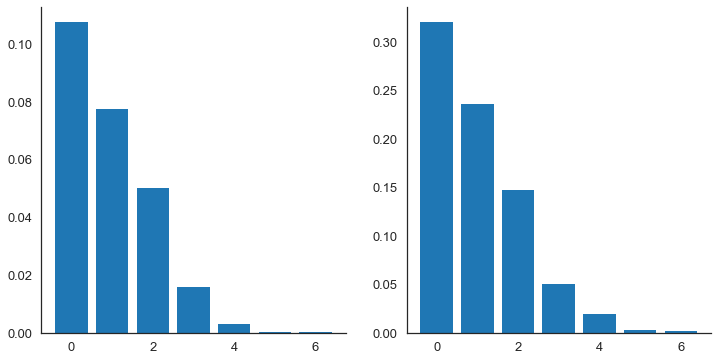

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(np.arange(7), err2_dist)
axes[1].bar(np.arange(7), err3_dist)

sns.despine()

In [95]:
err2_tidy = pd.melt(
    type2_errors_by_feature_count,
    var_name='Num Features', value_name='Error Count'
)

err2_tidy['dummy'] = err2_tidy['Error Count']

err2_sum_piv = err2_tidy.pivot_table(
    index='Num Features', values='Error Count', 
    aggfunc=np.sum
)

err2_len_piv = err2_tidy.pivot_table(
    index='Num Features', values='Error Count',
    aggfunc=len
)

err2_sum_piv / err2_len_piv

,Error Count
Num Features,
0,1.558662
1,1.120614
2,0.728344
3,0.228618
4,0.045779
5,0.001371
6,0.004112


In [96]:
err2_tidy.head()

,Num Features,Error Count,dummy
0,0,1.0,1.0
1,0,1.0,1.0
2,0,1.0,1.0
3,0,2.0,2.0
4,0,0.0,0.0


In [97]:
err2_len_piv = err2_tidy.pivot_table(
    index='Num Features', columns='Error Count', values='dummy',
    aggfunc=len
)

err2_len_piv.fillna(0)

Error Count,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0
Num Features,,,,,,,,,,,
0,1100.0,999.0,722.0,426.0,210.0,105.0,40.0,23.0,11.0,11.0,1.0
1,1499.0,1020.0,612.0,310.0,142.0,47.0,15.0,3.0,0.0,0.0,0.0
2,1999.0,966.0,447.0,167.0,52.0,14.0,3.0,0.0,0.0,0.0,0.0
3,2976.0,532.0,119.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3489.0,151.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3643.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3633.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
err2_sum_piv = err2_tidy.pivot_table(
    index='Num Features', columns='Error Count', values='dummy',
    aggfunc=np.sum
)

p_num_err2_j_num_feat = err2_sum_piv.fillna(0) / err2_tidy['Error Count'].sum()

In [116]:
p_num_feat = instances_by_feature_count.sum() / instances_by_feature_count.sum().sum()
p_num_feat

0    0.540799
1    0.276910
2    0.127894
3    0.040220
4    0.012153
5    0.001157
6    0.000868
dtype: float64

In [135]:
p_num_feat.sum()

1.0

In [137]:
p_num_err2_j_num_feat.sum().sum()

1.0

In [130]:
p_num_err2_c_num_feat = p_num_err2_j_num_feat.copy()
p_num_err2_c_num_feat.loc[:, :] = p_num_err2_j_num_feat.values / p_num_feat.values[:, np.newaxis]
p_num_err2_c_num_feat

Error Count,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,12.0
Num Features,,,,,,,,,,,
0,0.0,0.137323,0.198493,0.175674,0.115467,0.072167,0.032990,0.022131,0.012097,0.013609,0.00165
1,0.0,0.273826,0.328592,0.249665,0.152484,0.063087,0.024161,0.005638,0.000000,0.000000,0.00000
2,0.0,0.561490,0.519639,0.291207,0.120900,0.040688,0.010463,0.000000,0.000000,0.000000,0.00000
3,0.0,0.983295,0.439895,0.110898,0.007393,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.0,0.923665,0.097872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5,0.0,0.321142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
6,0.0,1.284567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [139]:
p_num_err2_c_num_feat.sum(axis=1)

Num Features
0    0.781600
1    1.097453
2    1.544387
3    1.541481
4    1.021537
5    0.321142
6    1.284567
dtype: float64

In [106]:
err2_tidy['Error Count'].sum()

13452.0

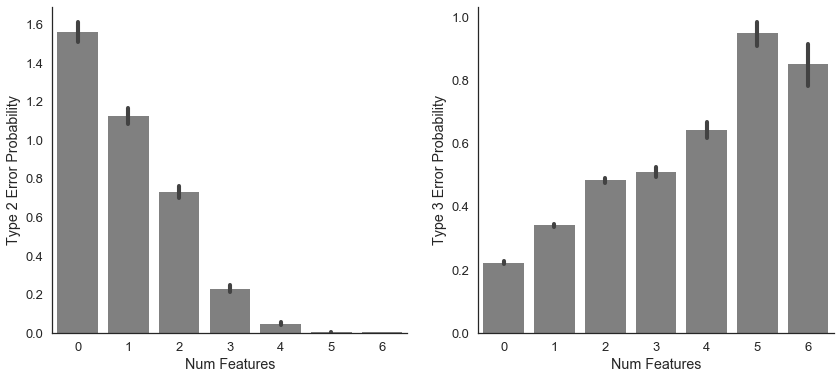

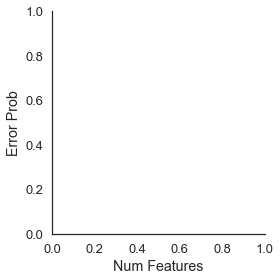

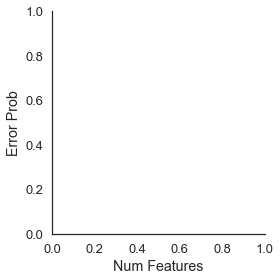

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))



err3_tidy = pd.melt(
    type3_errors_by_feature_count / instances_by_feature_count, 
    var_name='Num Features', value_name='Error Prob'
)

sns.factorplot(
    x='Num Features', y='Error Prob', data=err2_tidy, ax=axes[0],
    kind='bar', ci=95, n_boot=1000, color='grey'
)

sns.factorplot(
    x='Num Features', y='Error Prob', data=err3_tidy, ax=axes[1],
    kind='bar', ci=95, n_boot=1000, color='grey'
)


plt.setp(axes[0], ylabel='Type 2 Error Probability')
plt.setp(axes[1], ylabel='Type 3 Error Probability')

sns.despine(ax=axes[0])
sns.despine(ax=axes[1])

In [76]:
tidy['Type III Errors'].sum() / tidy['Num Pieces'].sum()

0.0686441318814277

In [212]:
dustarts

_idx = list(range(36))[8:40:8]

_l = np.zeros(36)
_l[_idx] = 1
_l.reshape((4, 9))

print(list(range(36))[5:45:10])

row = sum_df.iloc[0]

row.index

In [4]:
position_string = tidy.iloc[0]['Black Position']
feature = '1010'
start, end = 0, 4

print(position_string)
position_string[start:end] == feature
position_string[start:end:9] == feature



In [142]:
row = tidy.iloc[0]
bpi = row['Black Position']
bpf = row['Black Position (final)']
wpi = row['White Position']
wpf = row['White Position (final)']

error_counts = errors(row)
print(''.join([str(i) for i in error_counts['Type 2']]))

001000000000001000000000000010110011


In [148]:
initial = ''.join([str(int(b) + int(w)) for b, w in zip(bpi, wpi)])
final = ''.join([str(int(b) + int(w)) for b, w in zip(bpf, wpf)])

In [150]:
print(initial)
print(''.join([str(i) for i in error_counts['Type 2']]))
print(final)

001100000011011000011100000011110011
001000000000001000000000000010110011
000100000011110010011111100001000100


In [153]:
print(bpi)
print(wpf)
print(''.join([str(i) for i in error_counts['Type 3']]))


000000000011010000010100000001010001
000100000000100010001011000000000100
000100000011110010011111100001000100


In [93]:
start = 1
position_string[start:start+28:9]

'0110'

In [48]:
def position_string_to_array(position_string):
    position_list = np.stack([int(c) for c in position_string]).reshape((4, 9))
    
    return position_list

black_positions = np.stack(tidy['Black Position'].map(position_string_to_array).values)

In [50]:
black_positions[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 1]])

In [17]:
black_positions.shape

(3648, 4, 9)

In [30]:
feature1 = np.array([1, 1, 0, 0])
feature2 = np.array([1, 0, 1, 0])
feature3 = np.array([1, 0, 0, 1])
feature4 = np.array([1, 1, 1, 0])
feature5 = np.array([1, 1, 0, 1])
feature6 = np.array([1, 1, 1, 1])

def count_feature_occurrences(positions, feature):
    counts = np.zeros_like(positions)
    pass
    
    

In [31]:
position_string = tidy.iloc[0]['Black Position']

In [34]:
position = np.stack([c for c in position_string]).astype(np.uint8)

In [35]:
position

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1], dtype=uint8)

In [43]:
feature = np.zeros_like(position)
start, end = 0, 4
all(position[np.arange(start, end, 1)] == feature1)

False

In [21]:
from scipy.signal import convolve2d

In [41]:
feature = feature1
convolve2d(black_positions[0], feature[np.newaxis, :], mode='same') == feature.sum()

array([[False, False, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False]])

In [29]:
black_positions[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 1]])